In [1]:
import tensorflow as tf
print(tf.__version__)
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(24,20))
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
import os
os.sys.path.append('/home/schr476/Documents/fermilab-accelerator-ai/control-for-accelerators-in-hep/')

2.2.0


In [2]:
from dataprep.DataGenerator import DataGenerator
filename = '../data/MLParamData_1575356421.3855522_From_MLrn_2019-12-02+00:00:00_to_2019-12-03+00:00:00.h5_processed.h5'
training_generator = DataGenerator(filename,variables=['B:VIMIN','B:IMINER'],batch_size=111)
validation_generator = DataGenerator(filename,variables=['B:VIMIN','B:IMINER'],batch_size=111)
batch_x, batch_y = training_generator.__getitem__(3000)
#print(batch_x[1,-1,0])
#print(batch_y[0,0])
print(batch_x.shape)
print(batch_y.shape)

['ACNET']
['ACNET']
(111, 200, 2)
(111, 2)


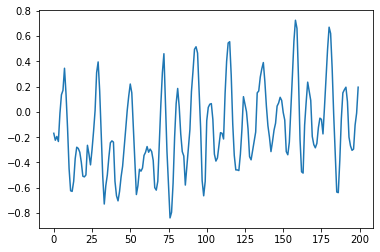

In [3]:
#plt.plot(batch_x[0,:,0])
plt.plot(batch_x[0,:,1])

In [4]:
import keras 
from keras.optimizers import  SGD, Adam
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GaussianNoise,BatchNormalization
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.regularizers import l1, l2, l1_l2
def build_model(backward,forward,variables):
    model = Sequential()
    model.add(LSTM(56, activation='tanh',
                   return_sequences=True,input_shape=(backward,variables)))
    model.add(BatchNormalization())
    #model.add(GaussianNoise(0.1))
    model.add(LSTM(56, activation='tanh',
                   return_sequences=True))
    #model.add(GaussianNoise(0.1))
    model.add(LSTM(56, activation='tanh',
                   kernel_regularizer=l1_l2(0.001,0.001),
                   ))
    #model.add(GaussianNoise(0.1))
    model.add(Dense(variables,activation='linear'))
    opt = Adam(lr=1e-2,clipnorm=1.0, clipvalue=0.5)
    model.compile(loss='mean_squared_error', optimizer=opt)
    model.summary()
    return model

In [ ]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=5, min_lr=1e-6,verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto', baseline=None, restore_best_weights=False)

backward=batch_x.shape[1]
forward=batch_y.shape[1]
nvars=batch_x.shape[2]
print(backward)
print(forward)
print(nvars)

model = build_model(backward,forward,nvars)
model.summary()
history = model.fit_generator(training_generator,validation_data=validation_generator,epochs=25,
                              use_multiprocessing=True,workers=6,
                              callbacks=[reduce_lr,early_stopping], verbose=1)

200
2
2
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 200, 56)           13216     
_________________________________________________________________
batch_normalization_1 (Batch (None, 200, 56)           224       
_________________________________________________________________
lstm_4 (LSTM)                (None, 200, 56)           25312     
_________________________________________________________________
lstm_5 (LSTM)                (None, 56)                25312     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 114       
Total params: 64,178
Trainable params: 64,066
Non-trainable params: 112
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)      

In [ ]:
val_x, val_y = validation_data
y_predict = model.predict(val_x)

In [ ]:
print(val_x.shape)
print(y_predict)
plt.plot(val_y)
plt.plot(y_predict)